# Titanic Passenger Survival Prediction

In [434]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns                      
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split          
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [435]:
#como hay clas imbalance ver como hacer bien los graficos 
#Ver si pasar age a distintos grupos tipo 0-10, 10-20 o hacer rounding
#cuanta gente tiene floating point sin ser aquellos de 0 a 1
#como solo importa en age si sobreviviste si sos muy chico o muy grande capaz es mejor hacer distintos grupos -> corroborar con la diferencia entre survived y deceased en cada age
#Ver que hacer con fate (lo mismo que age)


#Hacer un loop que pruebe todas las combinaciones posibles y me diga cual es la mejor combinacion 
#L1 regularization y te da los features necesarios -> ponerle todas hasta las nuevas columnas creadas

## 1.  Data Loading and Initial Exploration 


● Are data accessible?


○ Existence: the dataset is available in an Excel format.

○ Access to the data: it has been downloaded from Kaggle, a well-known platform for machine-learning datasets

○ Availability: the data has been provided by the professor, so there is no need to generate it.

○ Copyright, Legal permission, anonymity, or redistribution: the dataset license is unknown, its legal status for redistribution and commercialization is unclear. However, since this project is for academic purposes it should be acceptable.

○ Issues of privacy or confidentiality: passengers' information is publicly available over historical records so there are no confidentiality issues.

○ Generation rate: direct or by proxy (e.g., labelers, 3rd party providers): the source is unknown, there has not been updates for 5 years so it might be incomplete or out-of-date.

● Do we know whether data are reliable? Can we trust the labels? 
According to Wikipedia there were 2,225 passengers aboard the RMS Titanic, which sank after colliding with an iceberg in the Atlantic Ocean while en route to New York City. Only 712 of the 2,225 people on board (counting passengers and crew) survived.


○ We can perform (manual, automated) validation of quality on a subset of the data.
○ Are labels delayed? We observe labels now but use them to predict far future events.
○ Are labels indirect? Indicates a weak correlation with the prediction target (e.g., page interest)

### OVERVIEW

Dependent Variable: Survived

Independent variables: name, sex, age, sibsp, parch, ticket, fate, cabin, embarked, boat, body, home.dest.

In [509]:
df = pd.read_excel('titanic3.xls')
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [510]:
df.tail(5) 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN


**Categorical Features:**


    survival: 
Survival status (0 = No, 1 = Yes). 

Categorical (Binary: 0 or 1)


    class: 
Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd).

Categorical (Ordinal: 1st, 2nd, 3rd class)


    name: 
Name.

Categorical (Text, Identifier)


    sex: 
Sex.

Categorical (Nominal: Male, Female)

    ticket: 

Ticket Number.

Categorical (Text, Identifier)

    cabin: 
Cabin.

Cabin is conformed of letters and numbers. Apparently the letter represents the deck where the cabin was located at.

Categorical (Text, Identifier)

    embarked: 
Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton).
Categorical (Nominal: C, Q, S)

    boat: 
Lifeboat (if survived).

Categorical (Nominal: Yes or No, or a specific boat number)

    body: 
Body number (if did not survive and the body was recovered).

Categorical (Identifier, could be numeric but represents a categorical feature)

**Numerical Features:**

    sibsp: 
Number of Siblings/Spouses Aboard.

Numerical (Discrete: Integer)

    parch: 
Number of Parents/Children Aboard.

Numerical (Discrete: Integer)

    fare: 
Passenger Fare.

Numerical (Continuous: Float/Decimal)

In [438]:
df.shape

(1309, 14)

In [439]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [440]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape) 

number of duplicate rows:  (0, 14)


In [441]:
df.nunique()

pclass          3
survived        2
name         1307
sex             2
age            98
sibsp           7
parch           8
ticket        939
fare          281
cabin         186
embarked        3
boat           28
body          121
home.dest     369
dtype: int64

#### Data Leakage

"Boat" and "Body" features are direct indicators of survival or not, which are inherently tied to the prediction target. 

The "Boat" feature indicates whether a passenger was placed on a lifeboat, which is only relevant for survivors. Including this feature would give the model access to the outcome (survival) during training, causing data leakage.

The "Body" feature refers to the body number, which is assigned to passengers who did not survive, revealing the passenger has passed away. Including this feature would directly reveal the outcome (not surviving), again leading to data leakage. 

By eliminating these features directly from the dataset we prevent data leakage, which occurs when the prediction target is implicitly contained in the training dataset. This would lead to an overly optimistic performance and a model that would not be capable of generalizing to unseen data.

In [511]:
df = df.drop(['body', 'boat'], axis=1)
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


In [512]:
df.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


### VISUALIZATIONS AND EXPLORATORY STATISTICS

#### Plots

Numerical variables: age, sibsp, parch, fate
Categorical variables: survived, pclass, sex, ticket, cabin, embarked

In [513]:
#Letter extraction from cabin and missing values
df_subset = df["cabin"].dropna().astype(str).str[0]  # first letter
df_subset.head()

0    B
1    C
2    C
3    C
4    C
Name: cabin, dtype: object

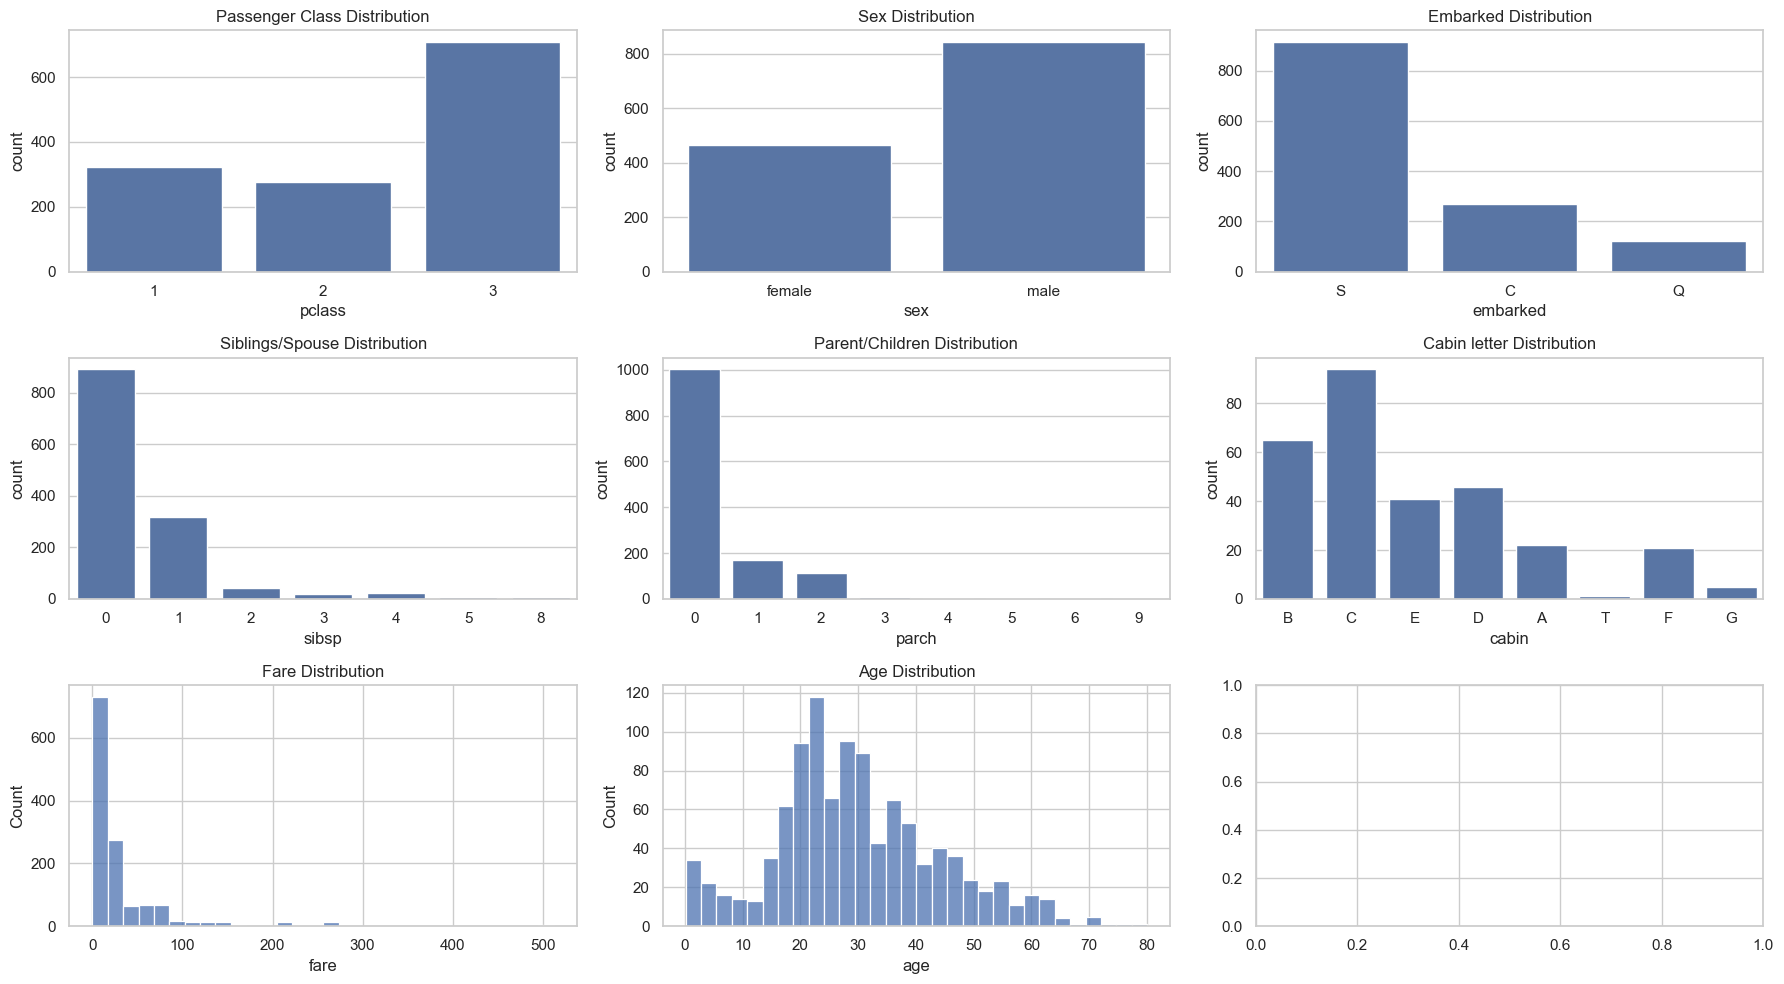

In [445]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 10))

# Distribution Pclass
sns.countplot(x='pclass', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Passenger Class Distribution')

# Distribution Sex
sns.countplot(x='sex', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Sex Distribution')

# Distribution Embarked
sns.countplot(x='embarked', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Embarked Distribution')

#Distribution siblings/spouses
sns.countplot(x='sibsp', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Siblings/Spouse Distribution')

#Distribution parent/children
sns.countplot(x='parch', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Parent/Children Distribution')

#Distribution cabin by letter
sns.countplot(x=df_subset, ax=axes[1, 2])
axes[1, 2].set_title('Cabin letter Distribution')

# Distribution Fare
sns.histplot(df['fare'].dropna(), bins=30, ax=axes[2, 0])
axes[2, 0].set_title('Fare Distribution')

# Distribution Age
sns.histplot(df['age'].dropna(), bins=30, ax=axes[2, 1])
axes[2, 1].set_title('Age Distribution')


plt.tight_layout()
plt.show()


ANALYSIS:

Understanding the distribution and balance of classes:

Since there are aroun 180 cabins in the dataset I have decided to look at the distribution based on the deck where the cabin was located at.


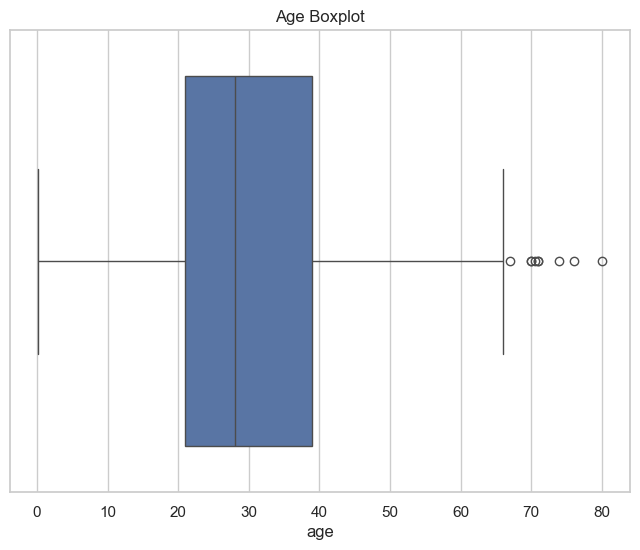

In [505]:
# Box plot for Fare

# Box plot for Age
plt.figure(figsize=(8, 6))
sns.boxplot(x='age', data=df)
plt.title('Age Boxplot')
plt.show()

COMPARISONS BETWEEN INDEPENDENT VARIABLES AND DEPENDENT VARIABLE

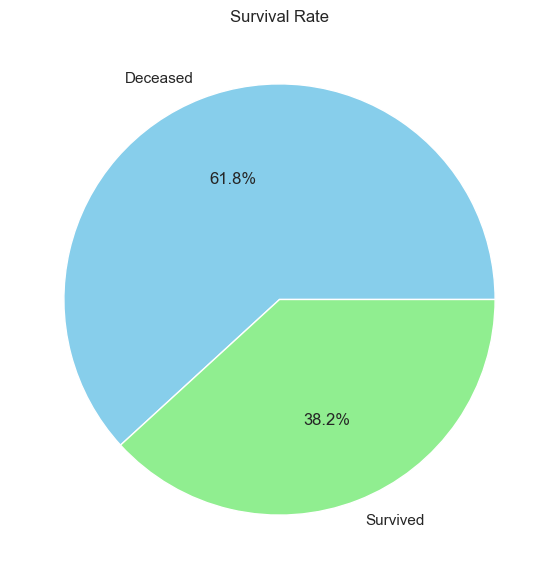

In [447]:
survival_counts = df['survived'].value_counts()
data = survival_counts.values
labels = ['Deceased', 'Survived']

fig = plt.figure(figsize=(10, 7))
plt.title("Survival Rate")
plt.pie(data, labels=labels, autopct='%1.1f%%', colors = ['skyblue', 'lightgreen'])

plt.show()

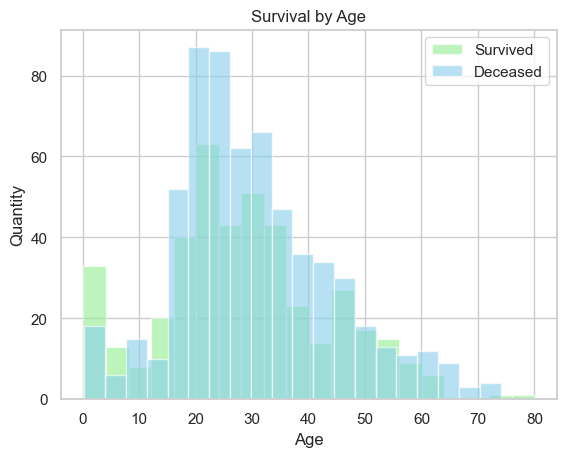

In [448]:
#Survived
plt.hist(df[df['survived'] == 1]['age'].dropna(), bins=20, alpha=0.6, label='Survived', color='lightgreen')

# Deceased
plt.hist(df[df['survived'] == 0]['age'].dropna(), bins=20, alpha=0.6, label='Deceased', color='skyblue')

plt.xlabel('Age')
plt.ylabel('Quantity')
plt.title('Survival by Age')
plt.legend()
plt.show()

porcentaje del total en vez de quantity porque no representa ya que hay mas deceased que survived

In [449]:
#VER SI HACER EXPLORATORY ANALYSIS DE FAMILY SIZE ACA O DESPUES


In [450]:
#df['familysize'] = df['sibsp'] + df['parch'] + 1
#plt.figure(figsize=(8, 6))
#sns.boxplot(x='familysize', data=df, palette=['lightgreen'])
#plt.title('Family Size Box Plot')
#plt.show()


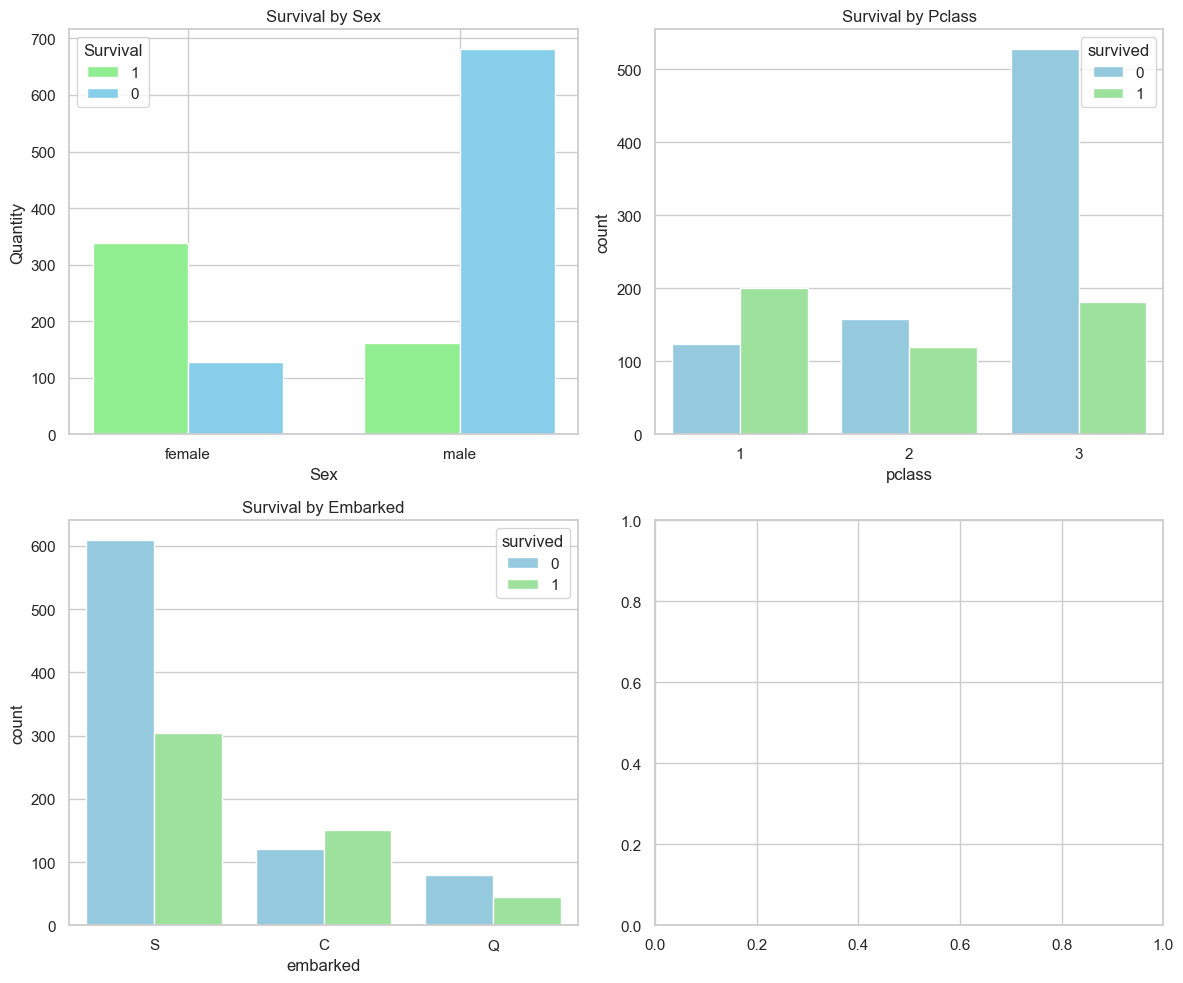

In [451]:

# Assuming you have already imported and prepared 'df' dataset

# Create a figure with multiple subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Survival by Sex (Bar plot)
counts = df.groupby(['sex', 'survived']).size().unstack()
survived = counts[1]
deceased = counts[0]
bar_width = 0.35
x = np.arange(len(counts.index))

axes[0, 0].bar(x - bar_width/2, survived, bar_width, label='1', color='lightgreen')
axes[0, 0].bar(x + bar_width/2, deceased, bar_width, label='0', color='skyblue')
axes[0, 0].set_xlabel('Sex')
axes[0, 0].set_ylabel('Quantity')
axes[0, 0].set_title('Survival by Sex')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(counts.index)
axes[0, 0].legend(title='Survival')

# Plot 2: Survival by Pclass (Count plot)
sns.countplot(x='pclass', hue='survived', data=df, palette=['skyblue', 'lightgreen'], ax=axes[0, 1])
axes[0, 1].set_title('Survival by Pclass')

# Plot 3: Survival by Embarked (Count plot)
sns.countplot(x='embarked', hue='survived', data=df, palette=['skyblue', 'lightgreen'], ax=axes[1, 0])
axes[1, 0].set_title('Survival by Embarked')

# Plot 4: Survival by Family Size (Count plot)
#sns.countplot(x='familysize', hue='survived', data=df, palette=['skyblue', 'lightgreen'], ax=axes[1, 1])
#axes[1, 1].set_title('Survival by Family Size')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## 2. Missing Values

Falta justificar age y fare

In [452]:
df.count() #check columns with missing values

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
home.dest     745
dtype: int64

In [453]:
missing_val = df.isnull().sum()
missing_percentage = round((missing_val/len(df)) * 100, 2)
table = pd.DataFrame({'Missing Values': missing_val, 'Missing Percentage': missing_percentage})

print(table)

           Missing Values  Missing Percentage
pclass                  0                0.00
survived                0                0.00
name                    0                0.00
sex                     0                0.00
age                   263               20.09
sibsp                   0                0.00
parch                   0                0.00
ticket                  0                0.00
fare                    1                0.08
cabin                1014               77.46
embarked                2                0.15
home.dest             564               43.09


#### a. Cabin

Strategy chosen: Imputation

In data exploration, I noticed that tickets are not unique and that, in fact, they might be related to cabins. It seems that perhaphs each cabin corresponded to a unique ticket number or that families traveling together could be assigned the same cabin.

So, the first step I'm taking is to check whether either of these patterns holds true for every record in the dataset or if there are inconcistencies that need to be addressed.

If the pattern holds, I could use the ticket / family information to impute the missing cabin values. Since some tickets / families have an associated cabin, while others don't i could identify the records with complete cabin data and then fill in the missing cabin for records sharing the same ticket number / family name. 

In [454]:
#RELATIONSHIP TICKET-CABIN

# Filter missing values for cabin
df_filtered = df[df['cabin'].notna()]

# Group by 'ticket' and check if all cabin values in each group are the same
ticket_cabin_check = df_filtered.groupby('ticket')['cabin'].nunique()

# Tickets where there is more than one unique cabin: 
inconsistent_tickets = ticket_cabin_check[ticket_cabin_check > 1]

#print("Inconsistent tickets:")
#print(inconsistent_tickets)

print("Number of inconsistencies:")
print(inconsistent_tickets.count())


Number of inconsistencies:
25


In [455]:
#RELATIONSHIP FAMILY-CABIN

#isnce the last name is the first word in the name we will extract it and use it for comparison  -> cannot do this! De La Cruz for example
#take the whole thing until the ,

def extract_last_name(name):
    name_parts = name.split(',')
    last_name = name_parts[0].strip()
    return last_name

last_name_filtered = df['name'].apply(extract_last_name)

last_name_df = df.copy()
last_name_df['last_name'] = last_name_filtered

family_cabin_check = last_name_df.groupby('last_name')['cabin'].nunique()


inconsistent_last_names = family_cabin_check[family_cabin_check > 1]

print("Number of inconsistencies:")
print(inconsistent_last_names.count())

Number of inconsistencies:
16


In my analysis, I initially assumed that the ticket-cabin relationship could be used to fill in the missing cabin values. However, I discovered that there are several inconsistencies that prevent this approach from working reliably. 


Using imputation methods like the mode, median, or mean isn't appropriate here. For instance, if I were to use the mode, it would suggest that a large number of passengers share the same cabin, which is unrealistic. Given the high number of missing values, it wouldn't make sense for a substantial portion of the passengers to end up with the same cabin.

The median and mean also fall short because the cabin values include letters. 

Therefore, I've decided to fill in the missing cabin entries with "unknown." This is since the first letter of the cabin represents the deck, and that detail could influence survival outcomes, perhaps due to differences in proximity to the lifeboats.

In [514]:
df['cabin'] = df['cabin'].fillna('Unknown')
df['cabin'].isnull().sum()

np.int64(0)

In [515]:
df.head(12)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,Unknown,C,"Montevideo, Uruguay"


#### b. Embarked

Strategy chosen: Imputation

In [458]:
missing_embarked = df[df["embarked"].isnull()]
print(missing_embarked)

     pclass  survived                                       name     sex  \
168       1         1                        Icard, Miss. Amelie  female   
284       1         1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      age  sibsp  parch  ticket  fare cabin embarked       home.dest  
168  38.0      0      0  113572  80.0   B28      NaN             NaN  
284  62.0      0      0  113572  80.0   B28      NaN  Cincinatti, OH  


Since there are only two missing values in the variable "Embarked", filling them with the most common port of embarkation ensures that the overall distribution remains nearly unchanged, minimizing the risk of introducing bias. 

Additionally, as "Embarked" is a categorical variable, using the mode, which represents the most frequent category, is a logical choice for imputation.

In [516]:
mode_embarked = df['embarked'].mode()[0]
df['embarked'] = df['embarked'].fillna(mode_embarked)

In [460]:
print(df.loc[[168]])

     pclass  survived                 name     sex   age  sibsp  parch  \
168       1         1  Icard, Miss. Amelie  female  38.0      0      0   

     ticket  fare cabin embarked home.dest  
168  113572  80.0   B28        S       NaN  


In [461]:
print(df.loc[[284]])

     pclass  survived                                       name     sex  \
284       1         1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      age  sibsp  parch  ticket  fare cabin embarked       home.dest  
284  62.0      0      0  113572  80.0   B28        S  Cincinatti, OH  


#### c. Age

Strategy chosen: Imputation

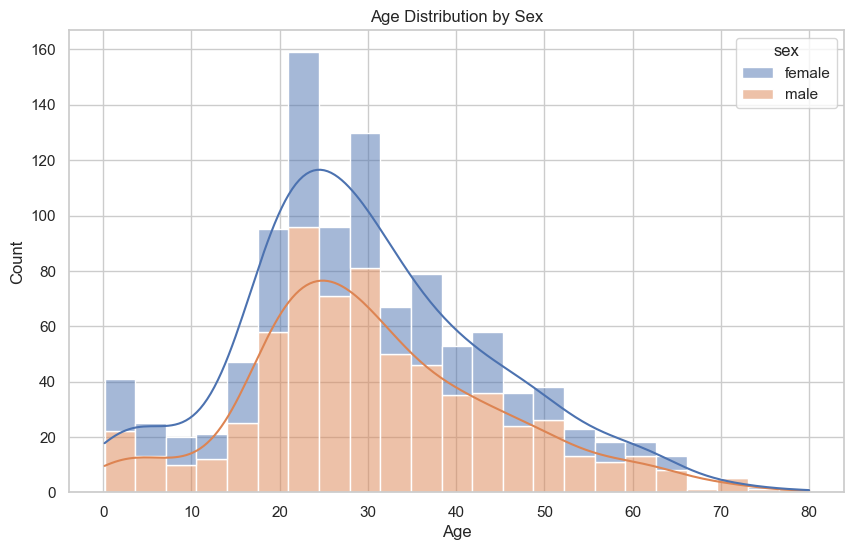

In [500]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your Titanic DataFrame with 'Age' and 'Sex' columns
plt.figure(figsize=(10, 6))

# Create the histogram plot for age distribution by sex
sns.histplot(df, x='age', hue='sex', multiple='stack', kde=True)

# Adding titles and labels
plt.title("Age Distribution by Sex")
plt.xlabel("Age")
plt.ylabel("Count")

# Show the plot
plt.show()


/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/2359549041.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pclass', y='age', data=df, palette='Set2')


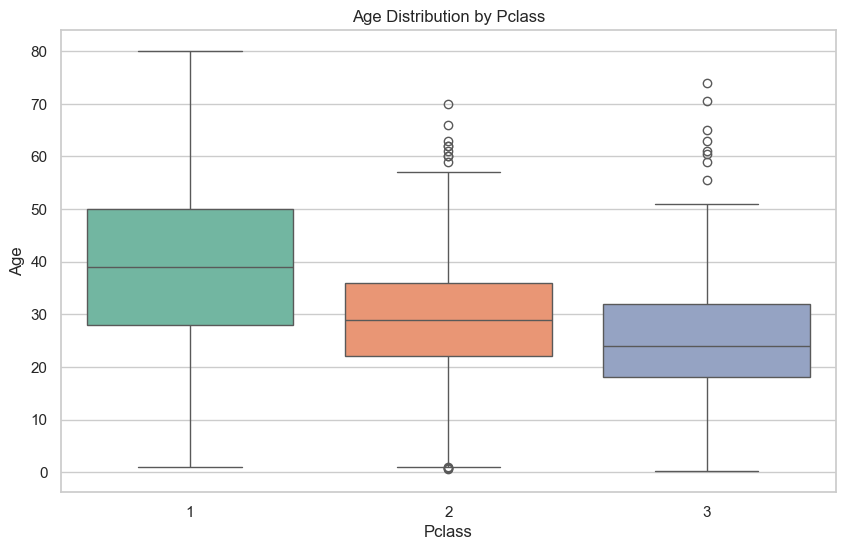

In [503]:
plt.figure(figsize=(10, 6))

# Create a boxplot to visualize Age distribution by Pclass
sns.boxplot(x='pclass', y='age', data=df, palette='Set2')

# Adding titles and labels
plt.title("Age Distribution by Pclass")
plt.xlabel("Pclass")
plt.ylabel("Age")

# Show the plot
plt.show()


For Pclass 1 (1st class), the median age is around 40-45, for Pclass 2 (2nd class), it's closer to 30, and for Pclass 3 (3rd class), it's closer to 25.

When looking at the heatmap we realize they have the highest correlation. 


Mean by sex?
Median by sex?
Median / mean
Mean by pclass?



In [517]:
mean_age_female = df[df['sex'] == 'female']['age'].mean()
mean_age_male = df[df['sex'] == 'male']['age'].mean()

# Replace missing values with respective mean values
df.loc[(df['sex'] == 'female') & (df['age'].isnull()), 'age'] = mean_age_female
df.loc[(df['sex'] == 'male') & (df['age'].isnull()), 'age'] = mean_age_male

# Check if there are any remaining missing values
df['age'].isnull().sum()

np.int64(0)

#### d. Fare

Strategy chosen: Deletion

Approach 1: 
For the Fare variable, which has only one missing value and a highly left-skewed distribution, I chose to impute the missing value using the median. 

In a left-skewed distribution, extreme low values can pull the mean downward, making it less representative of the central tendency of the data. 

The median, being more robust to outliers, provides a more typical value for the majority of observations, ensuring that the imputed value accurately reflects the common fare paid by passengers without being unduly influenced by the skewness of the distribution.

In [463]:
#median_fare = df['fare'].median()
#df['fare'] = df['fare'].fillna(median_fare)
#df['fare'].isnull().sum()


np.int64(0)

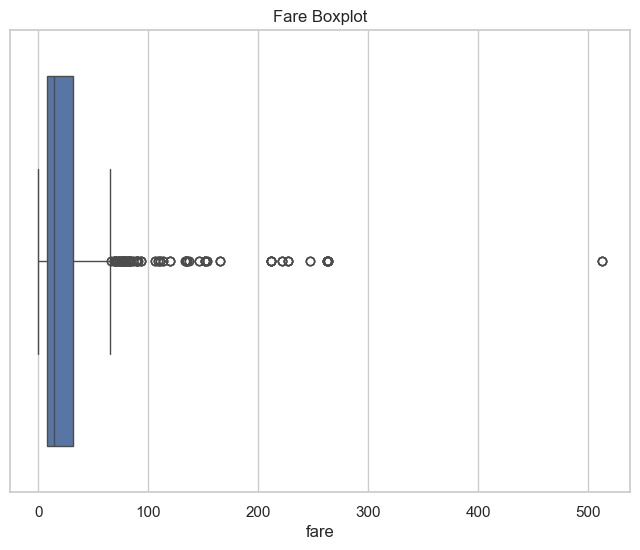

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='fare', data=df)
plt.title('Fare Boxplot')
plt.show()

Approach 2: 
Fare has a correlation of 0.24 with the target variable, Survival, which indicates a weak relationship. While there is a positive correlation (people who paid higher fares tend to have a slightly higher probability of survival), this relationship is weak. 

At the same time fare has a very high variance due to its right skewed distribution. This might make the model focus too much on the outliers leading to overfitting, reducing its predictive power to new unseen data.



Correlación entre Fare y Supervivencia: 0.24426546891481227


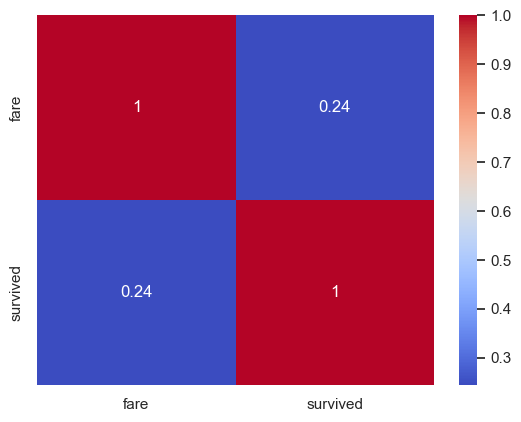

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la correlación entre 'Fare' y 'Survived'
correlation = df['fare'].corr(df['survived'])
print(f"Correlación entre Fare y Supervivencia: {correlation}")

# Mostrar la correlación en un gráfico
sns.heatmap(df[['fare', 'survived']].corr(), annot=True, cmap="coolwarm")
plt.show()


In [518]:
df = df.drop(columns=['fare'])

#### e. Home.dest

Strategy chosen: Deletion

The feature home.dest includes a total of 564 missing values. Out of the 745 values present in the dataset 369 of them are unique.
Around 43% of values are missing, and out of those present, almost 50% are unique.

A large proportion of missing values can potentially lead to bias  or noise if filled with the mean or median. Probably affecting the overall model performance.
The fact that almost 50% are unique means that values are quite specific, increasing sparsity of data. This will probably make the model struggle to capture any meaningful pattern.

Moreover, with so many unique categories, encoding them would lead to a very high dimensional dataset that may lead to overfitting because the model would be learning very specific details that do not generalize well to unseen data.

There is also no clear logical reason for why a passenger's home destination  would directly influence their survival. Other variables like gender or age make more sense to include in the model

In [464]:
df.nunique()

pclass          3
survived        2
name         1307
sex             2
age           100
sibsp           7
parch           8
ticket        939
fare          281
cabin         187
embarked        3
home.dest     369
dtype: int64

In [519]:
df = df.drop(columns=['home.dest'])

In [520]:
df.isnull().sum()

pclass      0
survived    0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
cabin       0
embarked    0
dtype: int64

Learning Curves

● Practical way to determine whether we have enough training data.

● Curves: training and validation scores (y) for a number of examples (x)

● Diminishing return for the number of examples added (data cost!)

● Typical sublinear improvement of ML training performance.

● Reasons for the plateau:

○ Not enough informative features

○ Learning algorithm cannot train a complex enough model for the given data

● How to break the plateau:

○ Engineering additional features, e.g., combining existing features or adding indirect information

○ More powerful learning algorithms, e.g., ensemble learning or deep neural networks

## 3. Encoding Categorical Variables

Categorial variables:
pclass          0
survived        0 -> no encoding needed, binary
sex             0
ticket          0
cabin           0
embarked        0

home destination -> group by countries -> library?


pclass → Ordinal categorical (Passenger class: 1st, 2nd, 3rd) 

name → Nominal categorical (Passenger names) 

sex → Nominal categorical (Male, Female)

ticket → Nominal categorical (Ticket codes)

cabin → Nominal categorical (Cabin numbers)

embarked → Nominal categorical (Port of embarkation: C, Q, S)

home.dest → Nominal categorical (Home destination)

survived → Binary categorical (0 = No, 1 = Yes) 

methods
1. One-Hot Encoding

2. Dummy Encoding

3.Ordinal Encoding

4. Binary Encoding

5. Count Encoding

6. Target Encoding


Why Dummy Encoding for Logistic Regression?
Logistic regression assumes independent predictor variables.
One-hot encoding creates redundancy (e.g., knowing two of three embarked columns lets you infer the third).
Dummy encoding removes this redundancy, preventing multicollinearity.

In [521]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,C22 C26,S


In [522]:
# Embarked: One-Hot Encoding for 
df = pd.get_dummies(df, columns=["embarked"], drop_first=True)
df = pd.get_dummies(df, columns=["sex"], drop_first=True)

In [523]:
# Feature Engineering for Cabin (extract first letter)
df["cabin"] = df["cabin"].astype(str).str[0]  # first letter
df_copy = df #later used in heatmap

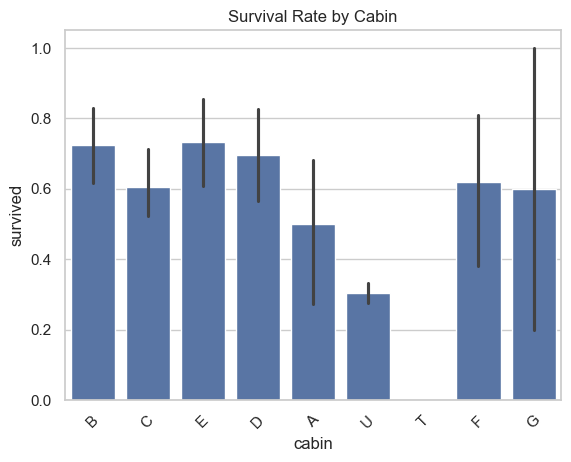

In [498]:
sns.barplot(x='cabin', y='survived', data=df)
plt.title('Survival Rate by Cabin')
plt.xticks(rotation=45)
plt.show()


One-Hot Encoding en lugar de Ordinal porque:

No hay una relación ordinal clara con la supervivencia:

B, E y C tienen tasas similares (alrededor de 70%)
Las tasas no siguen un patrón consistente de aumento o disminución
Por ejemplo, la cabina A tiene una tasa menor (~50%) que B, C, D y E
G tiene una tasa de supervivencia variable (barra de error grande)


La relación parece ser más nominal que ordinal:

Cada tipo de cabina parece tener su propia tasa de supervivencia distintiva
Las diferencias entre cabinas no siguen un orden lógico
Las barras de error (líneas negras) muestran solapamiento significativo

In [524]:
df = pd.get_dummies(df, columns=["cabin"], drop_first=True)

For cabin we extract the first letter and encode it since it means the deck where it was located
As seen in the overview cabin has 186 unique values.
It follows that Unknown will be cabin_U

With 186 unique values, one-hot encoding will create 186 new columns, which can significantly increase the dimensionality of your dataset. This is problematic for algorithms that suffer from the "curse of dimensionality," like linear models or models with regularization (like Lasso or Ridge regression).


Image: https://en.wikipedia.org/wiki/First-class_facilities_of_the_Titanic#/media/File:Olympic_&_Titanic_cutaway_diagram.png

Information: https://www.dummies.com/article/academics-the-arts/history/20th-century/titanic-facts-the-layout-of-the-ship-180759/

In [525]:
df.head()

,pclass,survived,name,age,sibsp,parch,ticket,embarked_Q,embarked_S,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U
0,1,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,False,True,False,True,False,False,False,False,False,False,False
1,1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,False,True,True,False,True,False,False,False,False,False,False
2,1,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,False,True,False,False,True,False,False,False,False,False,False
3,1,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,False,True,True,False,True,False,False,False,False,False,False
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,False,True,False,False,True,False,False,False,False,False,False


Label Encoding:
Each unique category is assigned a Unique Integer value.
This is a simpler encoding method, but it has a Drawback in that the assigned integers may be misinterpreted by the machine learning algorithm as having an Ordered Relationship when in fact they do not.


Cuantos unique tickets hay para ver si it makes sense encode it

## 7. Name: Feature Selection + Encoding

In [526]:
import re

# Función para extraer el título del nombre
def extract_title(name):
    # Usamos una expresión regular para encontrar la palabra antes del primer punto
    title = re.findall(r'([A-Za-z]+)\.', name)
    return title[0] if title else None  # Retorna el título encontrado, o None si no hay

# Aplicamos la función a la columna 'name' para crear una nueva columna 'title'
df['title'] = df['name'].apply(extract_title)

# Verificamos los primeros 5 registros
df.head(5)


,pclass,survived,name,age,sibsp,parch,ticket,embarked_Q,embarked_S,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,title
0,1,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,False,True,False,True,False,False,False,False,False,False,False,Miss
1,1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,False,True,True,False,True,False,False,False,False,False,False,Master
2,1,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,False,True,False,False,True,False,False,False,False,False,False,Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,False,True,True,False,True,False,False,False,False,False,False,Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,False,True,False,False,True,False,False,False,False,False,False,Mrs


In [ ]:
df.tail(5)

,pclass,survived,name,sex,age,ticket,fare,embarked,boat,body,...,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,familysize,title
1304,3,0,"Zabour, Miss. Hileni",female,14.5,2665,14.4542,C,NaN,328.0,...,False,False,False,False,False,False,False,True,2,Miss
1305,3,0,"Zabour, Miss. Thamine",female,NaN,2665,14.4542,C,NaN,NaN,...,False,False,False,False,False,False,False,True,2,Miss
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,2656,7.2250,C,NaN,304.0,...,False,False,False,False,False,False,False,True,1,Mr
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,2670,7.2250,C,NaN,NaN,...,False,False,False,False,False,False,False,True,1,Mr
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,315082,7.8750,S,NaN,NaN,...,False,False,False,False,False,False,False,True,1,Mr


In [ ]:
missing_values_count = df['title'].isnull().sum()
print(missing_values_count) #no missing values for title

0


In [ ]:
df['title'].nunique()

18

In [ ]:
df['title'].unique()

array(['Miss', 'Master', 'Mr', 'Mrs', 'Col', 'Mme', 'Dr', 'Major', 'Capt',
       'Lady', 'Sir', 'Mlle', 'Dona', 'Jonkheer', 'Countess', 'Don',
       'Rev', 'Ms'], dtype=object)

/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/1814431296.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='title', data=df, palette=['lightgreen'])


Text(0.5, 1.0, 'Title Box Plot')

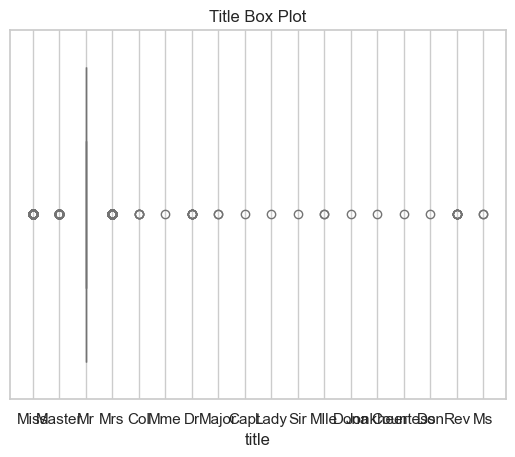

In [ ]:
#boxplot of titles -> many rare ones, many outliers, group as others
#Since i had an error when computing the title vs survival I realized
# Box plot Age
sns.boxplot(x='title', data=df, palette=['lightgreen'])
plt.title('Title Box Plot')

In [ ]:
title_counts = df['title'].value_counts()
print(title_counts)


title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Capt          1
Sir           1
Dona          1
Jonkheer      1
Countess      1
Don           1
Mme           1
Lady          1
Name: count, dtype: int64


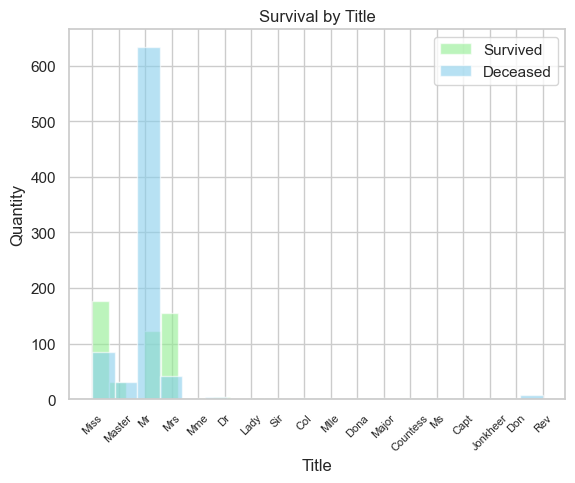

In [ ]:
# Plot for survived passengers
plt.hist(df[df['survived'] == 1]['title'].dropna(), bins=20, alpha=0.6, label='Survived', color='lightgreen')

# Plot for deceased passengers
plt.hist(df[df['survived'] == 0]['title'].dropna(), bins=20, alpha=0.6, label='Deceased', color='skyblue')

# Adding labels and title
plt.xlabel('Title')
plt.ylabel('Quantity')
plt.title('Survival by Title')
plt.legend()
plt.xticks(rotation = 45, fontsize=8)
plt.show()

Outliers 

In [527]:
# ESTO SOLO SE HACE SI LA DATA ESTA NORMALLY DISTRIBUTED
# IQR
Q1 = title_counts.quantile(0.25)
Q3 = title_counts.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as titles with frequencies below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outlier_threshold_lower = Q1 - 1.5 * IQR
outlier_threshold_upper = Q3 + 1.5 * IQR

# Get outliers based on frequency
outliers = title_counts[(title_counts < outlier_threshold_lower) | (title_counts > outlier_threshold_upper)]

print(outliers)

for i in range(len(df)): 
    if df['title'][i] not in outliers.index:
        df['title'][i] = 'Others'

print(df['title'].value_counts())

title
Mr        757
Miss      260
Mrs       197
Master     61
Name: count, dtype: int64
title
Mr        757
Miss      260
Mrs       197
Master     61
Others     34
Name: count, dtype: int64


/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/3108624286.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['title'][i] = 'Others'
/var/folders/_l/fwt_9dvs30g55rs94h95qn8w0000gn/T/ipykernel_64091/3108624286.py:18: Set

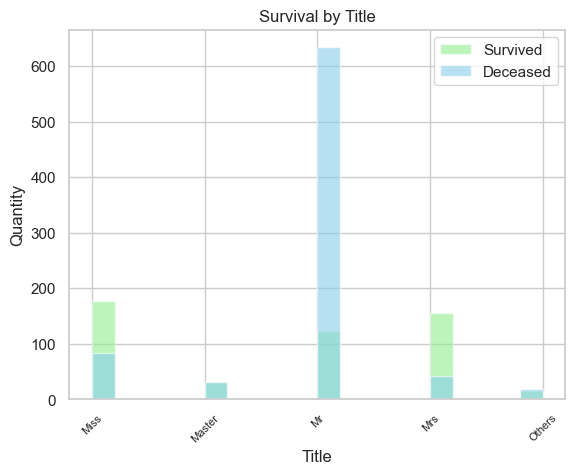

In [ ]:
# Plot for survived passengers
plt.hist(df[df['survived'] == 1]['title'].dropna(), bins=20, alpha=0.6, label='Survived', color='lightgreen')

# Plot for deceased passengers
plt.hist(df[df['survived'] == 0]['title'].dropna(), bins=20, alpha=0.6, label='Deceased', color='skyblue')

# Adding labels and title
plt.xlabel('Title')
plt.ylabel('Quantity')
plt.title('Survival by Title')
plt.legend()
plt.xticks(rotation = 45, fontsize=8)
plt.show()

 If there is a natural order to the titles (e.g., "Master" might indicate younger passengers).

In [ ]:
contingency_table = pd.crosstab(df['survived'], df['title'])

# Step 3: Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Step 4: Print the results
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")

Chi2 Statistic: 391.68398863664856
P-value: 1.7418882880240997e-83


In [ ]:
df = df.drop(columns=['name'])

,pclass,survived,sex,age,ticket,fare,embarked,boat,body,home.dest,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,familysize,title
0,1,1,female,29.0000,24160,211.3375,S,2,NaN,"St Louis, MO",True,False,False,False,False,False,False,False,1,Miss
1,1,1,male,0.9167,113781,151.5500,S,11,NaN,"Montreal, PQ / Chesterville, ON",False,True,False,False,False,False,False,False,4,Master
2,1,0,female,2.0000,113781,151.5500,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",False,True,False,False,False,False,False,False,4,Miss
3,1,0,male,30.0000,113781,151.5500,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",False,True,False,False,False,False,False,False,4,Mr
4,1,0,female,25.0000,113781,151.5500,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",False,True,False,False,False,False,False,False,4,Mrs


In [528]:
#Title Encoding
df = pd.get_dummies(df, columns=["title"], drop_first=True)

In [530]:
df = df.drop(columns=["name"])

In [531]:
df.head()

,pclass,survived,age,sibsp,parch,ticket,embarked_Q,embarked_S,sex_male,cabin_B,...,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,title_Miss,title_Mr,title_Mrs,title_Others
0,1,1,29.0000,0,0,24160,False,True,False,True,...,False,False,False,False,False,False,True,False,False,False
1,1,1,0.9167,1,2,113781,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,2.0000,1,2,113781,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,1,0,30.0000,1,2,113781,False,True,True,False,...,False,False,False,False,False,False,False,True,False,False
4,1,0,25.0000,1,2,113781,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


Extremely low -> PREDICTS A LOT -> NO DROPPING 
AND NO MISSING VALUES!

In [ ]:
df.head()

,pclass,survived,sex,age,ticket,fare,embarked,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,familysize,title_Miss,title_Mr,title_Mrs,title_Others
0,1,1,female,29.0000,24160,211.3375,S,True,False,False,False,False,False,False,False,1,True,False,False,False
1,1,1,male,0.9167,113781,151.5500,S,False,True,False,False,False,False,False,False,4,False,False,False,False
2,1,0,female,2.0000,113781,151.5500,S,False,True,False,False,False,False,False,False,4,True,False,False,False
3,1,0,male,30.0000,113781,151.5500,S,False,True,False,False,False,False,False,False,4,False,True,False,False
4,1,0,female,25.0000,113781,151.5500,S,False,True,False,False,False,False,False,False,4,False,False,True,False


CHECK CORRELATION BETWEEN TITLE AND SPOUSE CHILDREN ETC. porque generalmente es un indicador
ex. 
"Chibnall, Mrs.": This part typically indicates the surname and the title (in this case, "Mrs." indicates that the person is married). It follows the standard "Surname, Title" format used in the Titanic passenger records.

## 4. Feature scaling 

Weak rule of thumb:
● Normalization tends to work better for uniformly distributed data
● Standardization tends to work best for normally distributed data.

## 7. Sibsp and Parch: Feature Selection + Feature Scaling

Correlation Check: Check if sibsp and parch are strongly correlated (which they likely are). Highly correlated features might lead to multicollinearity, making it harder for some models to interpret them effectively. Combining them into one feature might help mitigate this issue.

In [ ]:
# Calculate the correlation between 'sibsp' and 'parch'
correlation = df[['sibsp', 'parch']].corr()

# Display the correlation matrix
print(correlation)


          sibsp     parch
sibsp  1.000000  0.373587
parch  0.373587  1.000000


The correlation coefficient between sibsp and parch is 0.37, which indicates a low to moderate positive correlation between the two features. While they are not highly correlated, this suggests that there is some relationship between the number of siblings/spouses aboard (sibsp) and the number of parents/children aboard (parch).

Given this moderate correlation, it is still reasonable to combine sibsp and parch into a new feature such as familysize.


In [532]:
df['family.size'] = df['sibsp'] + df['parch'] + 1
df = df.drop(columns = ['sibsp', 'parch'])
df.head()

,pclass,survived,age,ticket,embarked_Q,embarked_S,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,title_Miss,title_Mr,title_Mrs,title_Others,family.size
0,1,1,29.0000,24160,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,1
1,1,1,0.9167,113781,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,4
2,1,0,2.0000,113781,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,4
3,1,0,30.0000,113781,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,4
4,1,0,25.0000,113781,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,4


FROM EXPLORATORY ANALYSIS
Age Distribution: normal
Fare Distribution: left skewed

In [534]:
df = df.drop(columns = "ticket")

#DROP TICKETS? ES CATEGORICAL

In [536]:
from sklearn.preprocessing import StandardScaler

num_features = ["age", "family.size"]  

scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

df.head(5)

,pclass,survived,age,embarked_Q,embarked_S,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_U,title_Miss,title_Mr,title_Mrs,title_Others,family.size
0,1,1,-0.070589,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,-0.558346
1,1,1,-2.250248,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,1.336749
2,1,0,-2.166169,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,1.336749
3,1,0,0.007025,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,1.336749
4,1,0,-0.381046,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,1.336749


## 5. Data Splitting

In [537]:
#Splitting 80-10-10
train_df, others_df = train_test_split(df, test_size=0.2, stratify=df['survived'], random_state=2025)
#In machine learning, stratification is a technique used to ensure that the distribution of the target variable (or class labels) in the train, validation, and test sets is as similar as possible to the original dataset.

validation_df, test_df = train_test_split(others_df, test_size=0.5, stratify=others_df['survived'], random_state=2025)

# Distribution in each split -> same as whole dataset
print("Training set distribution:")
print(train_df['survived'].value_counts() / len(train_df))

print("\nValidation set distribution:")
print(validation_df['survived'].value_counts() / len(validation_df))

print("\nTest set distribution:")
print(test_df['survived'].value_counts() / len(test_df))

Training set distribution:
survived
0    0.617956
1    0.382044
Name: count, dtype: float64

Validation set distribution:
survived
0    0.618321
1    0.381679
Name: count, dtype: float64

Test set distribution:
survived
0    0.618321
1    0.381679
Name: count, dtype: float64


In [538]:
# Feature and Target division
x_train = train_df.drop(columns=['survived'])
y_train = train_df['survived']

x_val = validation_df.drop(columns=['survived'])
y_val = validation_df['survived']

x_test = test_df.drop(columns=['survived'])
y_test = test_df['survived']

## 6. Addressing Class Imbalance

Splitting data: 
● Rules of thumb to estimate the number of training examples needed for a problem:
○ 10 times the amount of features (often exaggerates the training set size, works as an upper bound) -> 10 x 7 = 70
○ 100 or 1000 times the number of classes (often underestimates the size) -> 200 a 2000

adasyn 
1600 records or 

smote
1018 records aprox

In [539]:
#smote
smote = SMOTE(sampling_strategy='auto', random_state=2025, k_neighbors=5)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

#'auto' is equivalent to 'not majority', meaning it resamples only the minority class to match the majority class.

In [ ]:
#adasyn
#adasyn = ADASYN(sampling_strategy='auto', random_state=2025, k_neighbors=5)
#x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)


## 7. Feature Selection

#### HeatMap

In [ ]:
#Ver si tengo que hacer todo el correlation map y eso con los datos despues de adasyn y smote o antes

En lugar de crear muchas columnas para cada letra de cabina, puedes agrupar las cabinas en categorías más generales que tengan sentido para tu análisis. Por ejemplo:

Primera clase, segunda clase, tercera clase (si las cabinas están relacionadas con la clase del pasajero).
Cabinas cercanas al puente (A, B, C) y cabinas más alejadas (D, E, F, etc.).
Cabinas con "Unknown" (para aquellas sin un valor claro).

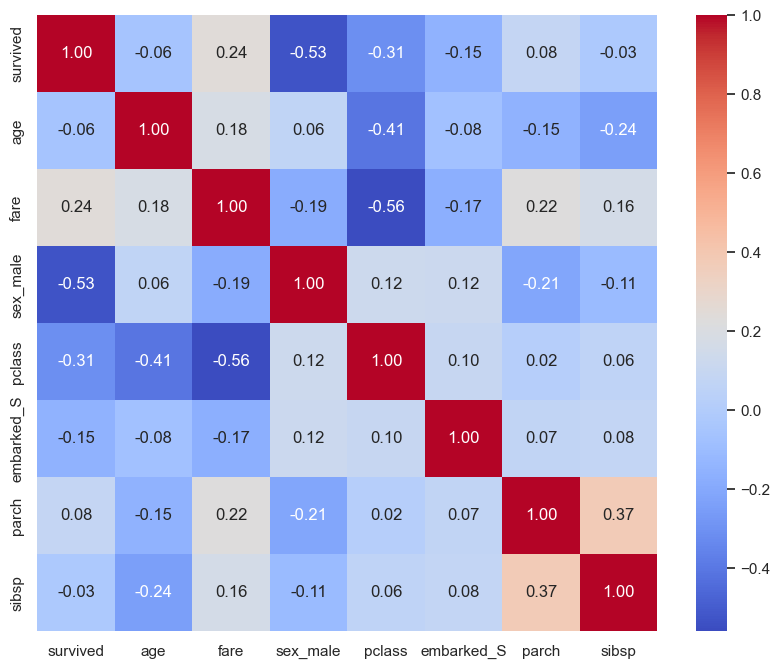

In [250]:
# Lista de columnas que deseas incluir en el heatmap
selected_columns = ['survived', 'age', 'fare', 'sex_male', 'pclass', 'embarked_S', 'parch', 'sibsp']

# Seleccionar solo las columnas de interés
df_selected = df[selected_columns]

# Calcular la matriz de correlación entre las columnas seleccionadas
correlation_matrix = df_selected.corr()

# Visualizar la matriz de correlación con un heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


Since pclass is hoghly correlated with fare and more correlated with survived than fare -> drop fare
Pero pclass esta mas correlated con cabin que fare
parch is also pretty correlated with sibsp -> put together

WHY DROPPING FARE?

1. pclass is more correlated with survived than fare

Since your goal is to predict survival, you should keep the features that have the strongest correlation with survived.

If pclass has a higher correlation with survived than fare, then pclass is likely the more important predictor.

2. pclass is also more correlated with cabin

If pclass is highly correlated with cabin, this suggests that pclass captures important structural information about where passengers were located on the ship.

cabin itself is an important feature because higher-class passengers were likely to have better access to lifeboats.

3. Multicollinearity Issue
If fare and pclass are highly correlated, including both could introduce multicollinearity, which can make models unstable and harder to interpret.

Since pclass is categorical and represents a clear distinction between socioeconomic groups, it is often more informative than fare, which can have more variability and outliers.



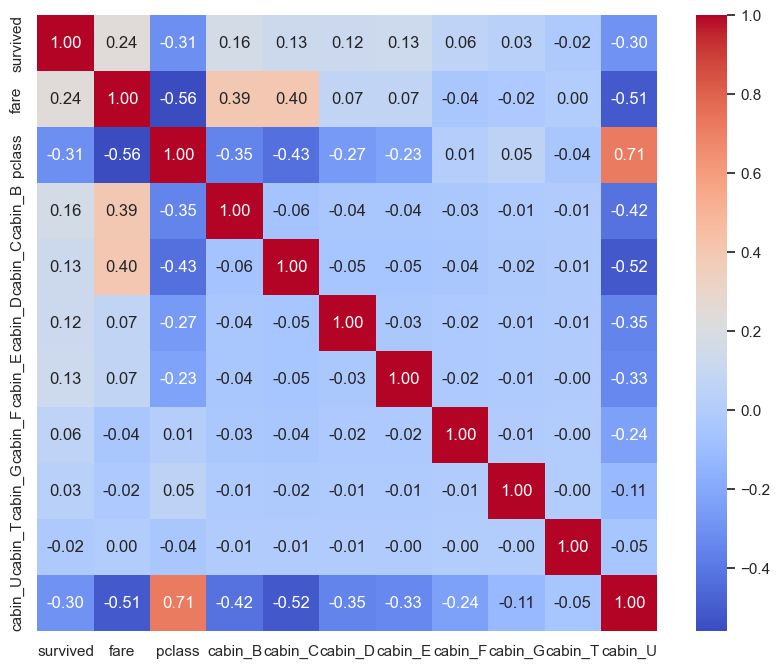

In [254]:
selected_columns = ['survived', 'fare', 'pclass']
selected_columns += [col for col in df.columns if col.startswith('cabin_')]

df_selected = df[selected_columns]

# Calcular la matriz de correlación entre las columnas seleccionadas
correlation_matrix = df_selected.corr()

# Visualizar la matriz de correlación con un heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()



#### PClass

In [302]:
#Percentage of Survival within each Cabin
survival_percentage_by_cabin = df_copy.groupby('cabin')['survived'].mean() * 100
print(survival_percentage_by_cabin)

cabin
A    50.000000
B    72.307692
C    60.638298
D    69.565217
E    73.170732
F    61.904762
G    60.000000
T     0.000000
U    30.276134
Name: survived, dtype: float64


El porcentaje de supervivientes en cuanto al total marcado por grupo

All but two lifeboats were situated on the Boat Deck, the highest deck of Titanic. 
-Wikipedia

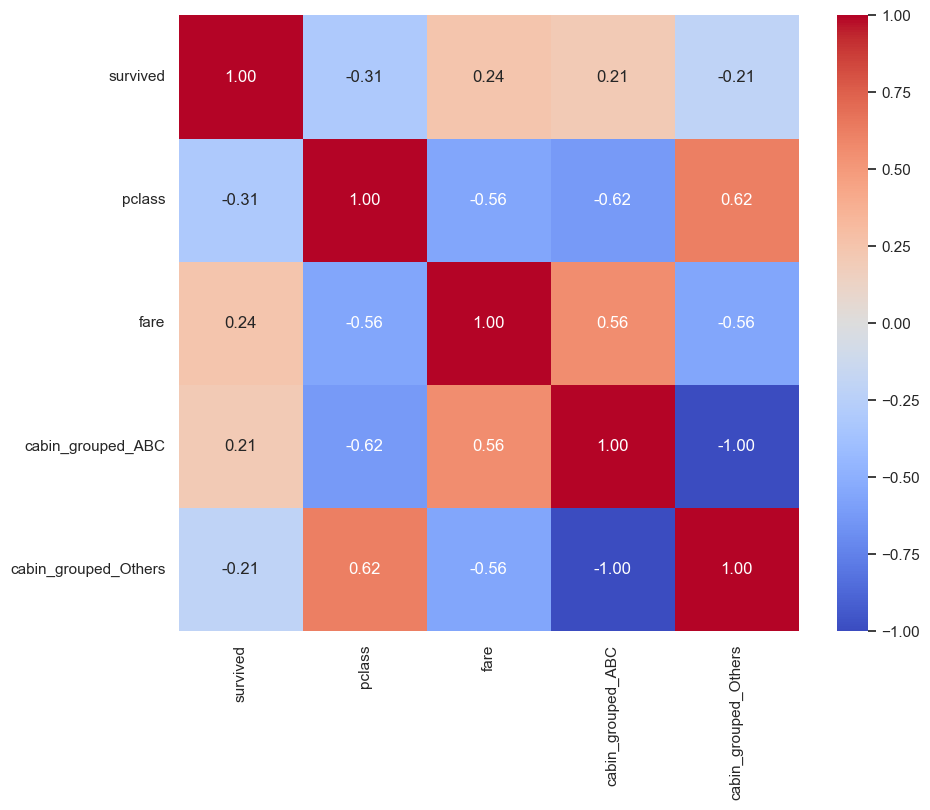

In [432]:
df_copy['cabin_grouped'] = np.where(df_copy['cabin'].isin(['A', 'B', 'C']), 'ABC', 'Others')

# Step 2: Perform One-Hot Encoding for 'cabin_grouped'
df_copy_encoded = pd.get_dummies(df_copy, columns=['cabin_grouped'], drop_first=False)

# Step 3: Select the columns of interest (including 'survived' and the encoded 'cabin_grouped')
selected_columns = ['survived', 'pclass','fare'] + [col for col in df_copy_encoded.columns if col.startswith('cabin_grouped_')]

df_selected = df_copy_encoded[selected_columns]

# Step 4: Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

#### Name

Done in feature encoding

7. FEATURE SELECTION Name:
No tiene valor predictivo: Los nombres son aleatorios y no tienen relación con la supervivencia. No contribuirán positivamente a un modelo.
Ruido: Mantenerla solo agregaría complejidad y ruido innecesario al modelo, ya que no está relacionada con los patrones de supervivencia.
Extraer informacion de Miss, Master, Mr., Mrs., Capt., Dr., Major., Mme., Lady., Sir., Col., Dona., Jonkheer

In [ ]:
#Cabin: misssing values 
#What is parch?, sibsp?


#Family number: sum parch and sibsp

#COLUMNS TO DROP:
#Boat -> NaN -> Tiene valor si sobrevivieron -> DATA LEARKAGE DROP!!!
#Survived
#Body: Number if survived -> DROP 

#home.dset -> NaN
#

## 8. Training a Logistic Regression Model

Drop fare
Drop home destination
Add Family Column from sibsp and parch
Add Title from name

pclass	title  sex	age	family	ticket	cabin	embarked

In [540]:
model = LogisticRegression(max_iter=1000)  

model.fit(x_train_smote, y_train_smote)

# Predictions
y_pred = model.predict(x_test)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8015267175572519
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        81
           1       0.71      0.80      0.75        50

    accuracy                           0.80       131
   macro avg       0.79      0.80      0.79       131
weighted avg       0.81      0.80      0.80       131

Confusion Matrix:
[[65 16]
 [10 40]]
